In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.mask import iou, encode
from pathlib import Path
import numpy as np

In [2]:
prefix = 'instances'
dataType = 'val2017'
# Replace the following line with the actual location of your COCO dataset
dataDir = Path('data/')

annFile = dataDir/'annotations'/f'{prefix}_{dataType}.json'
cocoGt = COCO(str(annFile))

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [3]:
from torchvision import transforms
from PIL import Image

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_image_filename(gt, imgId):
    return str(dataDir/dataType/gt.imgs[imgId]['file_name'])

def load_image(gt, imgId):
    input_image = Image.open(get_image_filename(gt, imgId)).convert('RGB')
    input_tensor = preprocess(input_image)
    input_tensor = input_tensor.unsqueeze(0)
    input_tensor = input_tensor.detach().cpu().numpy()
    
    return input_tensor

In [4]:
# Dictionary to do map between different category ids
# key = COCO id, value = Pascal VOC id
COCO_TO_VOC = {
    1: 15,  # person
    2: 2,   # bicycle
    3: 7,   # car
    4: 14,  # motorbike
    5: 1,   # airplane
    6: 6,   # bus
    7: 19,  # train
    9: 4,   # boat
    16: 3,  # bird
    17: 8,  # cat
    18: 12, # dog
    19: 13, # horse
    20: 17, # sheep
    21: 10, # cow
    44: 5,  # bottle
    62: 9,  # chair
    63: 18, # couch/sofa
    64: 16, # potted plant
    67: 11, # dining table
    72: 20, # tv
}

VOC_CAT_IDS = list(COCO_TO_VOC.keys())

def load_image_and_ann(gt, imgId):
    input_tensor = load_image(gt, imgId)
    
    _, _, height, width = input_tensor.shape
    output_tensor = np.zeros((21, height, width), dtype=np.uint8)
    
    annIds = gt.getAnnIds(imgId, VOC_CAT_IDS)
    for ann in gt.loadAnns(annIds):
        mask = gt.annToMask(ann)
        output_tensor[COCO_TO_VOC[ann['category_id']]] |= mask
        
    # Set everything not labeled to be background
    output_tensor[0] = 1 - np.max(output_tensor, axis=0)
    
    # Add extra dimension to comply with batch format
    output_tensor = output_tensor[np.newaxis, ...]
    
    return input_tensor, output_tensor

def getImgIdsUnion(gt, catIds):
  """
  Returns all the images that have *any* of the categories in `catIds`,
  unlike the built-in `gt.getImgIds` which returns all the images containing
  *all* of the categories in `catIds`.
  """
  imgIds = set()
  
  for catId in catIds:
      imgIds |= set(gt.catToImgs[catId])
      
  return list(imgIds)

imgIds = getImgIdsUnion(cocoGt, VOC_CAT_IDS)

In [5]:
from onnx import numpy_helper
import os
import onnxruntime as rt


# Start from ORT 1.10, ORT requires explicitly setting the providers parameter if you want to use execution providers
# other than the default CPU provider (as opposed to the previous behavior of providers getting set/registered by default
# based on the build flags) when instantiating InferenceSession.
# For example, if NVIDIA GPU is available and ORT Python package is built with CUDA, then call API as following:
# rt.InferenceSession(path/to/model, providers=['CUDAExecutionProvider'])
sess = rt.InferenceSession("models/fcn-resnet50-12.onnx")

def predict(sess, input_tensor):
    """
    Given an input tensor, create a (N, 21, height, width) one-hot
    binary mask of pixelwise class predictions
    """
    # The names for the FCN inputs/outputs are known, use them directly
    model_tensor = sess.run(["out"], {"input": input_tensor})[0]
    batch_size, nclasses, height, width = model_tensor.shape
    
    raw_labels = np.argmax(model_tensor, axis=1).astype(np.uint8)
    # We need to convert from the argmax of each pixel into a one-hot binary tensor,
    # which can be done with numpy's excellent boolean indexing
    output_tensor = np.zeros((nclasses, batch_size, height, width), dtype=np.uint8)
    
    for c in range(nclasses):
        output_tensor[c][raw_labels==c] = 1

    output_tensor = np.transpose(output_tensor, [1, 0, 2, 3])
    
    return output_tensor

def iou(model_tensor, target_tensor):
  # Don't include the background when summing
  model_tensor = model_tensor[:, 1:, :, :]
  target_tensor = target_tensor[:, 1:, :, :]
  
  intersection = np.sum(np.logical_and(model_tensor, target_tensor))
  union = np.sum(np.logical_or(model_tensor, target_tensor))
  
  if union == 0:
      # Can only happen if nothing was there and nothing was predicted,
      # which is a perfect score
      return 1
  else:
      return intersection / union

def pixelwise_accuracy(model_tensor, target_tensor):
    batch_size, nclasses, height, width = model_tensor.shape
    # Again, don't include the background in the accuracy
    total_pixels = batch_size * (nclasses - 1) * height * width
    model_tensor = model_tensor[:, 1:, :, :]
    target_tensor = target_tensor[:, 1:, :, :]
    
    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    return np.sum(model_tensor == target_tensor) / total_pixels

def compute_validation_accuracy(gt, sess, imgIds, print_every=50):
    """
    Given the ground truth annotations, compute the mean IoU and
    global pixelwise accuracy for a given model instantiated in sess
    on the image ids.
    
    This code is serial (non-batched) so it will be fairly slow.
    """
    
    totalIoU = 0
    totalAcc = 0
    totalImgs = len(imgIds)
    
    for i in range(totalImgs):
        imgId = imgIds[i]
        input_tensor, target_tensor = load_image_and_ann(gt, imgId)
        model_tensor = predict(sess, input_tensor)

        totalIoU += iou(model_tensor, target_tensor)
        totalAcc += pixelwise_accuracy(model_tensor, target_tensor)
        if print_every is not None and i % print_every == print_every - 1:
            print(f"Completed {i+1}/{totalImgs}.\tmean IoU: {totalIoU / (i+1)}\tGPA: {totalAcc / (i+1)}")
        
    return totalIoU / totalImgs, totalAcc / totalImgs

In [ ]:
meanIoU, gpa = compute_validation_accuracy(cocoGt, sess, imgIds)

In [7]:
from PIL import Image
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img = Image.open('data/val2017/000000031093.jpg').convert('RGB')
input_tensor = preprocess(img)
input_tensor = input_tensor.unsqueeze(0)
orig_tensor = input_tensor.detach().cpu().numpy()

one_output = predict(sess, orig_tensor)


(-0.5, 639.5, 425.5, -0.5)

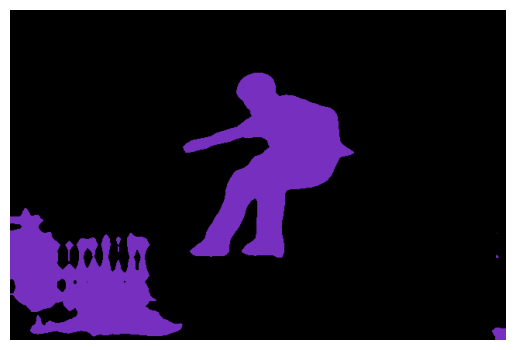

In [11]:
from PIL import Image
from matplotlib.colors import hsv_to_rgb
import numpy as np
import cv2

num_classes = 20

def get_palette():
    # prepare and return palette
    palette = [0] * num_classes * 3

    for hue in range(num_classes):
        if hue == 0: # Background color
            colors = (0, 0, 0)
        else:
            colors = hsv_to_rgb((hue / num_classes, 0.75, 0.75))

        for i in range(3):
            palette[hue * 3 + i] = int(colors[i] * 255)

    return palette

def colorize(labels):
    # generate colorized image from output labels and color palette
    result_img = Image.fromarray(labels).convert('P', colors=num_classes)
    result_img.putpalette(get_palette())
    return np.array(result_img.convert('RGB'))

def visualize_output(image, output):
    # assert(image.shape[0] == output.shape[1] and \
    #        image.shape[1] == output.shape[2]) # Same height and width
    # assert(output.shape[0] == num_classes)

    # get classification labels
    raw_labels = np.argmax(output, axis=0).astype(np.uint8)

    # comput confidence score
    confidence = float(np.max(output, axis=0).mean())

    # generate segmented image
    result_img = colorize(raw_labels)

    # generate blended image
    # blended_img = cv2.addWeighted(image[:, :, ::-1], 0.5, result_img, 0.5, 0)

    # result_img = Image.fromarray(result_img)
    # blended_img = Image.fromarray(blended_img)

    # return confidence, result_img, blended_img, raw_labels
    return result_img

result_img = visualize_output(orig_tensor[0], one_output[0])


plt.imshow(result_img)
plt.axis("off")


(-0.5, 639.5, 425.5, -0.5)

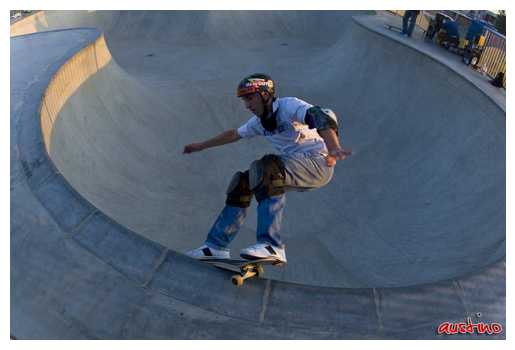

In [13]:
plt.imshow(img)
plt.axis('off')